In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [3]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

Mounted at /content/drive


In [5]:
# path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

In [ ]:
#### Droppa il primo caso e tiene il secondo con HBOND e VDW

#columns_to_check = df.columns[:-1]
#df_copy = df.copy()
#df = df.drop_duplicates(subset=columns_to_check, keep='last')

In [6]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [7]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

# Apply the mapping to create numerical labels
y = df['Interaction'].replace(contact_dict)
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

<ipython-input-7-1592439739>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


In [8]:
# Encode categorical features
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

In [9]:
# Count total missing values per column
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


In [10]:
# Fill None values with the mean of the values of that column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

In [11]:
print(X.head())

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
0 -2.322  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0   
1 -1.788  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0   
2 -2.390  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0   
3 -1.088 -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0   
4 -1.551 -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0   

   s_ss8_encoded  t_ss8_encoded  
0              3              7  
1              0              1  
2       

## Feature engineering


### `a5` product

The `a5` feature measures the eletrostatic charge of the amino acids.

This new engineered features, computed as `s_a5 * t_a5`, is a good indicator for mainly predicting **IONIC** bond, it measures the residues' charge: A positively charged residue (K, R have high positive a5) interacts with a negatively charged one (D, E have high negative a5). The product will be a large negative number.

In [23]:
X['a5_product'] = np.multiply(X['s_a5'], X['t_a5'])
print(X.head())

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   ...  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  s_ss8_encoded  \
0  ...  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0              3   
1  ...  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0              0   
2  ...  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0              2   
3  ... -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0              4   
4  ... -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0              0   

   t_ss8_encoded  a5_product  
0

### `a1` product

This new engineered features, computed as `s_a1 * t_a1`, is a good indicator for mainly predicting **VDW** and  bond, it measures polarity:
* A large positive product means either both are hydrophobic (- * - = +) or both are hydrophilic (+ * + = +).
* When combined with low RSA, a large positive a1_product strongly suggests a VDW interaction between two buried, hydrophobic residues.
* When combined with high RSA, it suggests a polar surface interaction, likely HBOND.

In [12]:
X['a1_product'] = np.multiply(X['s_a1'], X['t_a1'])
print(X.head())

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   ...  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  s_ss8_encoded  \
0  ...  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0              3   
1  ...  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0              0   
2  ...  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0              2   
3  ... -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0              4   
4  ... -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0              0   

   t_ss8_encoded  a1_product  
0

### `rsa` sum

### sequence distance

In [13]:
# Scale all features to the range [0, 1]
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)
input_dim = X_scaled.shape[1]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [16]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

0: 844743
1: 589649
2: 30626
3: 28313
4: 7108
5: 1680
6: 1432
7: 871637


In [17]:
sampling_strategy = {
    0: 844743,  # HBOND
    1: 589649,  # VDW
    2: 30626,  # PIPISTACK
    3: 50000,  # IONIC
    4: 30000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 871637   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_bal, y_bal = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_bal distribution')
for label in sorted(Counter(y_bal)):
    print(f"{label}: {Counter(y_bal)[label]}")


Resampled y_bal distribution
0: 844743
1: 589649
2: 30626
3: 50000
4: 30000
5: 10000
6: 10000
7: 871637


## 2 - LOAD Existing data


In [ ]:
# X_bal = np.load(path + '/X_bal-SMOTE22.npy')
# y_bal = np.load(path + '/y_bal-SMOTE22.npy')

In [ ]:
# print('Original y_train distribution:', Counter(y_train))
# print('Resampled y_bal distribution:', Counter(y_bal))

In [ ]:
# # Count the class in X_bal
# unique_values, counts = np.unique(y_bal, return_counts=True)
# print(dict(zip(unique_values, counts)))

In [18]:
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

## XGBoost

Helper functions

In [ ]:
def feature_importance(model, X_train, y_train, interaction_type):
  # Estrai le importanze delle feature
  importance = model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'
  # UPDATE WITH NEW ENGINEERED FEATURES
  feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
          't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]
  # Ordinare le feature per importanza
  # Create a mapping from old keys to new feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

  # Replace keys in the importance dictionary
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sort the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Visualizza l'importanza delle feature
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
  plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
  plt.show()

In [20]:
def compute_metrics(y_test, y_pred, y_pred_prob):
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.4f}')
  balanced_acc = balanced_accuracy_score(y_test, y_pred)
  print(f'Balanced Accuracy: {balanced_acc:.4f}')
  auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
  print(f'AUC-ROC: {auc_roc:.4f}')
  mcc = matthews_corrcoef(y_test, y_pred)
  print(f'Matthews Correlation Coefficient: {mcc:.4f}')
  average_precision = average_precision_score(y_test, y_pred_prob, average='weighted')
  print(f'Average Precision Score: {average_precision:.4f}')

In [21]:
def plot_confusion_matrix(y_test, y_pred, labels, interaction_type):
  cm = confusion_matrix(y_test, y_pred)
  labels = sorted(contact_dict.keys(), key=lambda x: contact_dict[x])  # Sort by dict values
  cm_df = pd.DataFrame(cm, index=labels, columns=labels)

  #plot
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix for {interaction_type} interaction')
  plt.show()

### Train loop

Training classifier for Class 0
[0]	validation-auc:0.62746
[100]	validation-auc:0.72200
[191]	validation-auc:0.72477

Binary Classification Report for Class 0
Accuracy: 0.6413
Balanced Accuracy: 0.6568


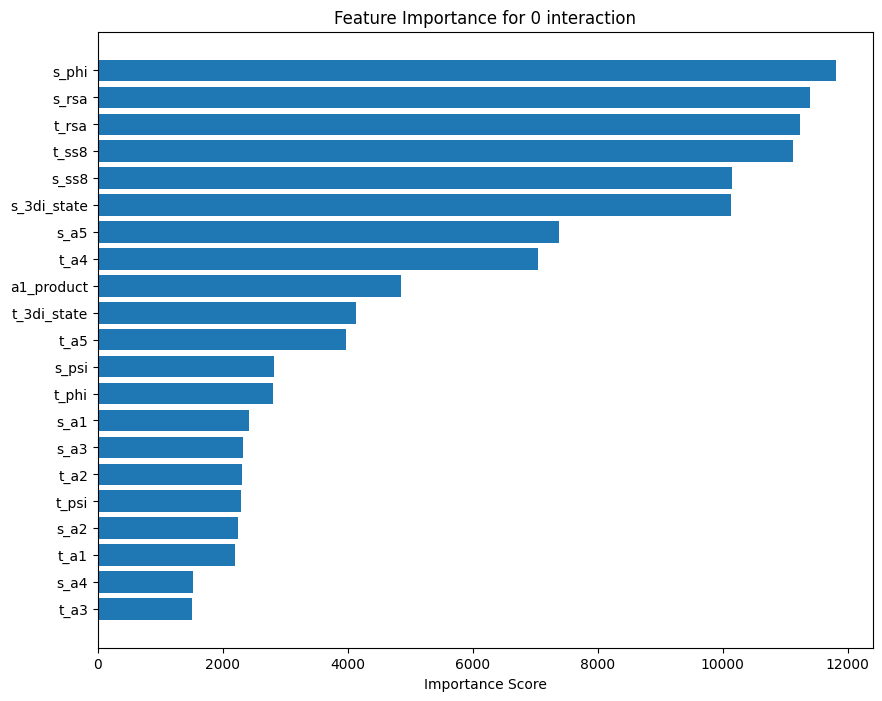

Training classifier for Class 1
[0]	validation-auc:0.54377
[52]	validation-auc:0.56225

Binary Classification Report for Class 1
Accuracy: 0.5195
Balanced Accuracy: 0.5360


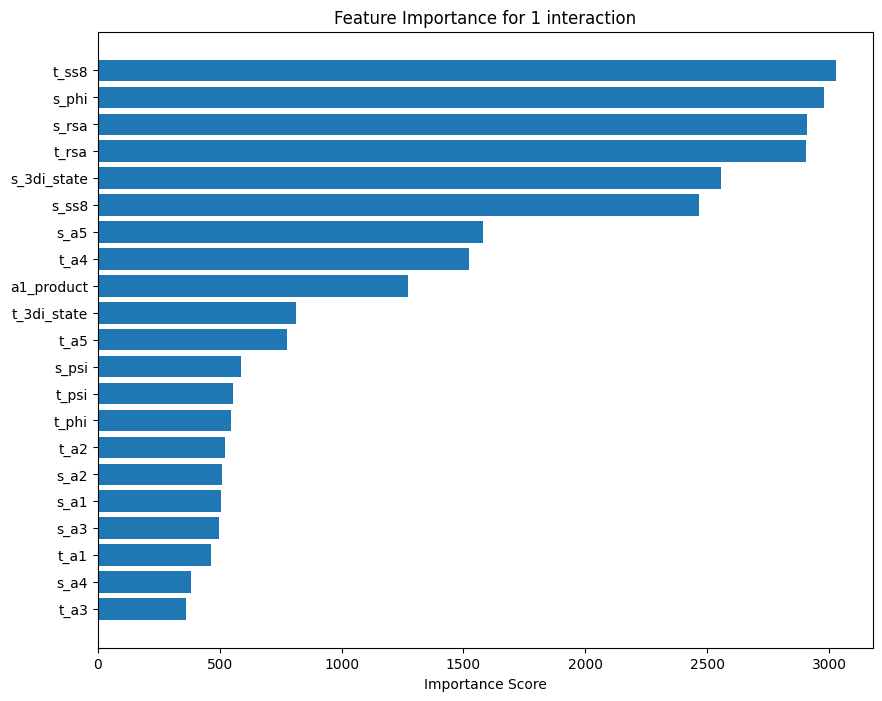

Training classifier for Class 2
[0]	validation-auc:0.98976
[66]	validation-auc:0.99090

Binary Classification Report for Class 2
Accuracy: 0.9791
Balanced Accuracy: 0.9869


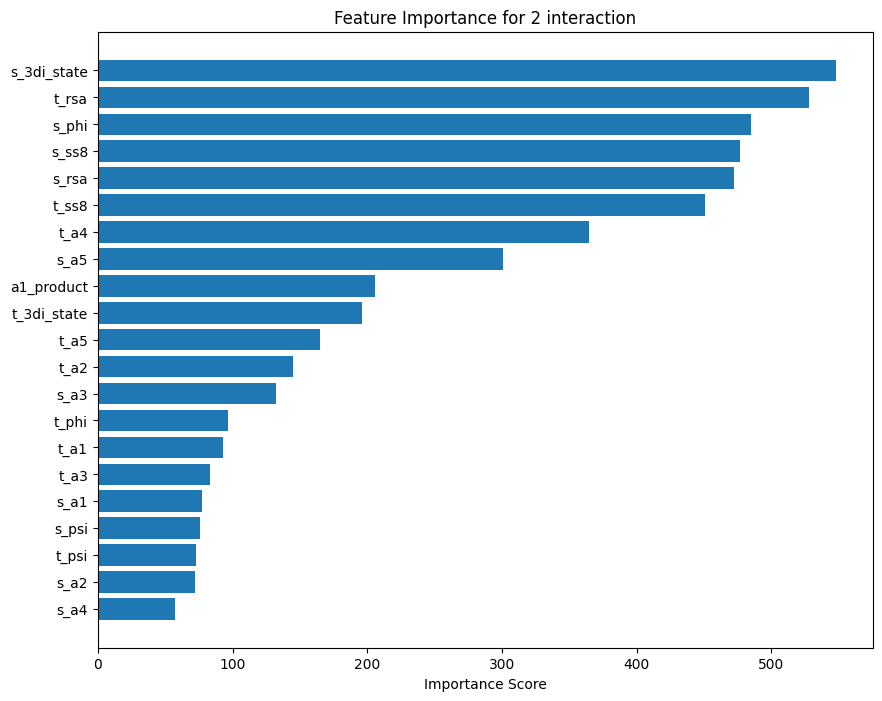

Training classifier for Class 3
[0]	validation-auc:0.97636
[76]	validation-auc:0.98430

Binary Classification Report for Class 3
Accuracy: 0.9461
Balanced Accuracy: 0.9479


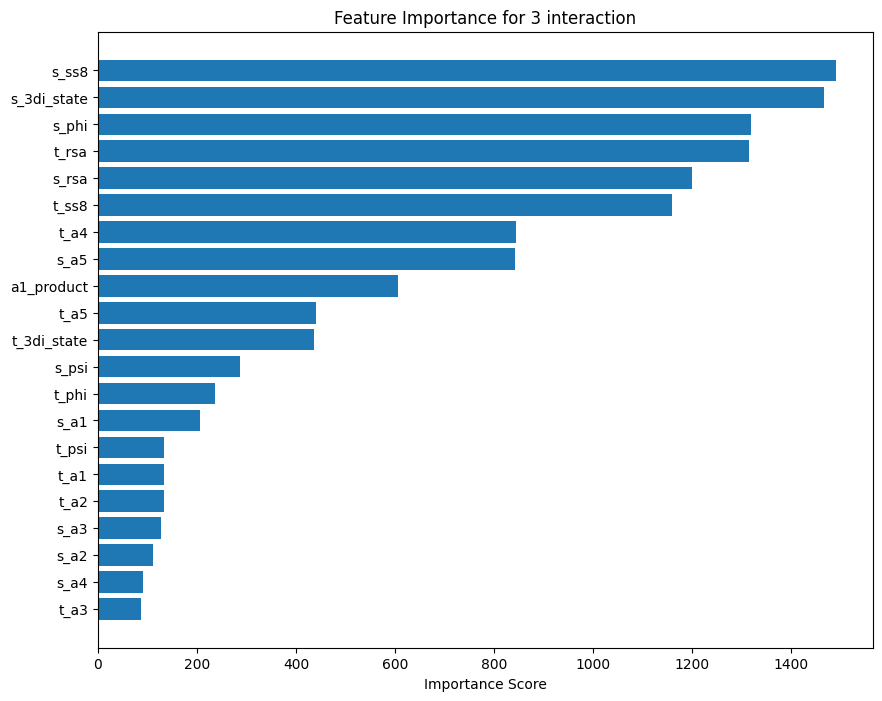

Training classifier for Class 4
[0]	validation-auc:0.96787
[100]	validation-auc:0.99760
[200]	validation-auc:0.99778
[268]	validation-auc:0.99781

Binary Classification Report for Class 4
Accuracy: 0.9923
Balanced Accuracy: 0.7251


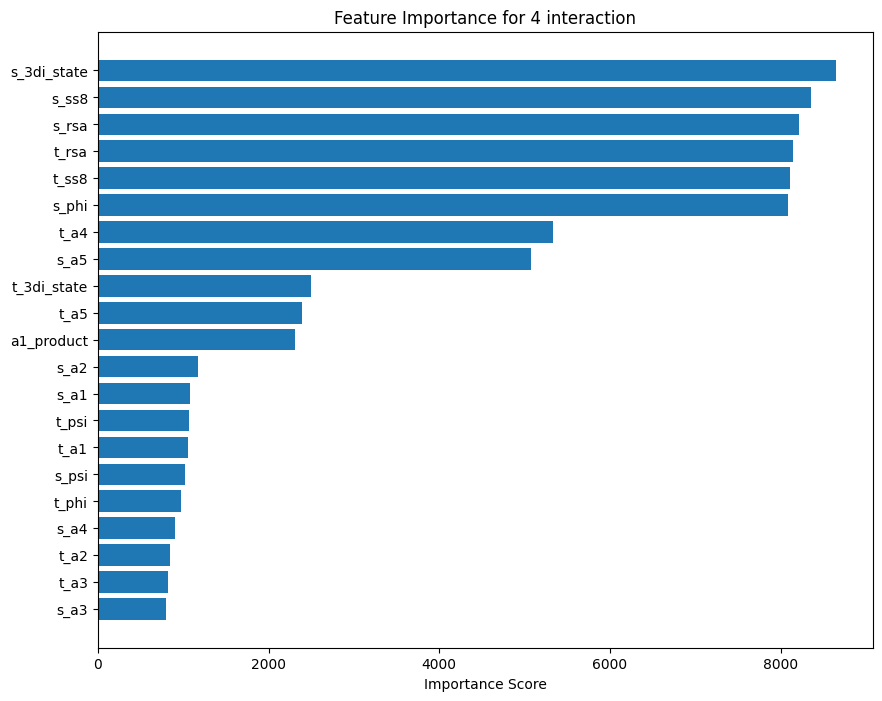

Training classifier for Class 5
[0]	validation-auc:0.99945
[92]	validation-auc:0.99985

Binary Classification Report for Class 5
Accuracy: 0.9991
Balanced Accuracy: 0.9091


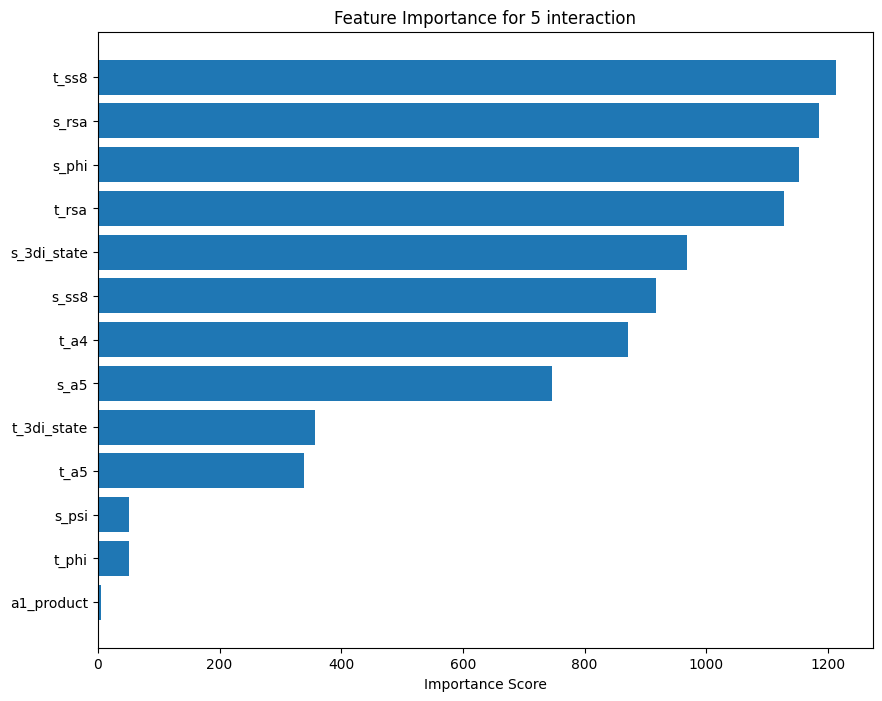

Training classifier for Class 6
[0]	validation-auc:0.95254
[100]	validation-auc:0.99724
[200]	validation-auc:0.99761
[241]	validation-auc:0.99766

Binary Classification Report for Class 6
Accuracy: 0.9988
Balanced Accuracy: 0.5877


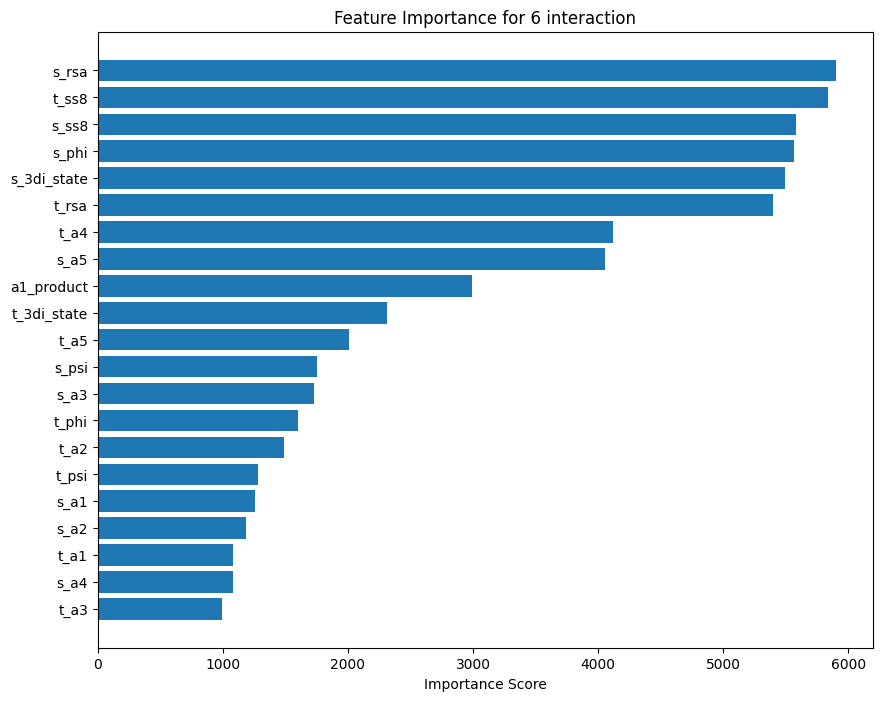

Training classifier for Class 7
[0]	validation-auc:0.66168
[100]	validation-auc:0.74809
[200]	validation-auc:0.76097
[300]	validation-auc:0.76803
[400]	validation-auc:0.77266
[500]	validation-auc:0.77628
[600]	validation-auc:0.77882
[700]	validation-auc:0.78111
[800]	validation-auc:0.78353
[900]	validation-auc:0.78553
[1000]	validation-auc:0.78690
[1100]	validation-auc:0.78833
[1200]	validation-auc:0.78967
[1300]	validation-auc:0.79058
[1400]	validation-auc:0.79181
[1500]	validation-auc:0.79281
[1600]	validation-auc:0.79371
[1700]	validation-auc:0.79462
[1800]	validation-auc:0.79537
[1900]	validation-auc:0.79616
[2000]	validation-auc:0.79687
[2100]	validation-auc:0.79765
[2200]	validation-auc:0.79824
[2300]	validation-auc:0.79885
[2400]	validation-auc:0.79955
[2499]	validation-auc:0.80019

Binary Classification Report for Class 7
Accuracy: 0.7332
Balanced Accuracy: 0.7127


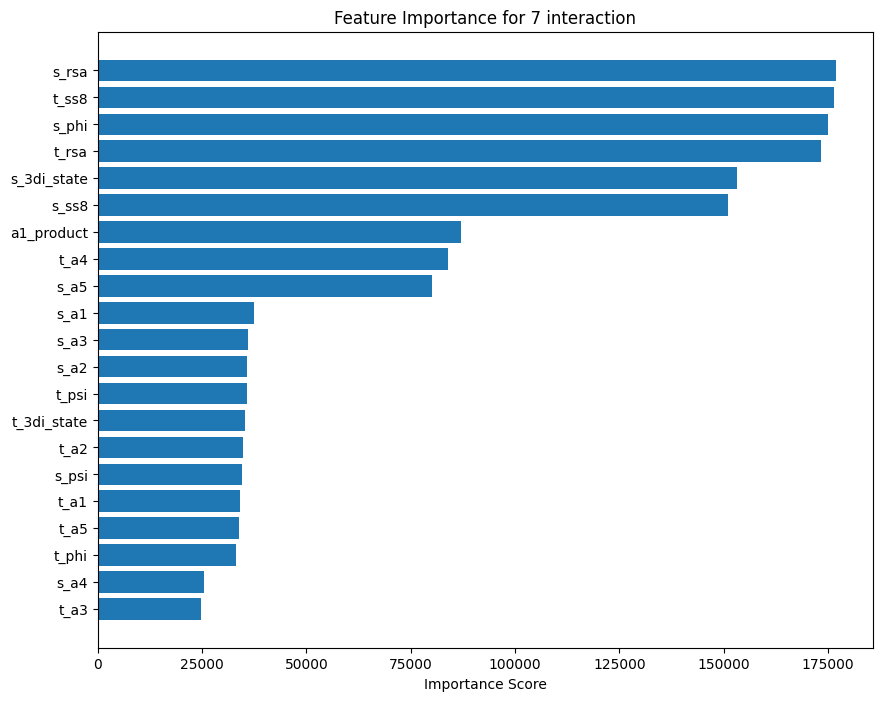

In [22]:
# Create arrays to store models and predictions
models = []
all_class_predictions = np.zeros((len(y_test), len(np.unique(y_bal))))  # y_bal

# For each class, train a binary classifier
for num_class in range(len(np.unique(y_bal))):  # y_bal
    print(f'Training classifier for Class {num_class}')

    # Create binary labels for ALL training examples
    # 1 for current class, 0 for all other classes
    X_train_binary = X_bal # X_bal
    y_train_binary = (y_bal == num_class).astype(int) # y_bal

    # Split into train/val
    X_train, X_val, y_train_bin, y_val_bin = train_test_split(
        X_train_binary,
        y_train_binary,
        test_size=0.2,
        random_state=42,
        stratify=y_train_binary  # Important for imbalanced data
    )

    # Binary labels for test data
    y_test_binary = (y_test == num_class).astype(int)

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train_bin)
    dval = xgb.DMatrix(X_val, label=y_val_bin)
    dtest = xgb.DMatrix(X_test, label=y_test_binary)

    # Counte num positive/negative examples for this class
    pos_class = np.sum(y_train_binary == 1)
    neg_class = np.sum(y_train_binary == 0)

    # Train model
    model = xgb.train(
        params = {
            'device': 'cuda',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 10,
            'learning_rate': 0.2,
            'scale_pos_weight': neg_class / pos_class if pos_class > 0 else 1.0,  # Handle class imbalance
            'seed': 42
        },
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dval, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=100
    )

    # Save model
    os.makedirs(os.path.join(path, 'models'), exist_ok=True)
    model.save_model(os.path.join(path, f'models/xgboost_model_class_{num_class}.json'))

    # Store predictions for this class
    y_pred_prob = model.predict(dtest)
    all_class_predictions[:, num_class] = y_pred_prob

    # Evaluate this binary classifier
    y_pred = (y_pred_prob > 0.5).astype(int)
    print(f"\nBinary Classification Report for Class {num_class}")
    print(f"Accuracy: {accuracy_score(y_test_binary, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test_binary, y_pred):.4f}")

    # Optional: Display feature importance for this classifier
    feature_importance(model, X_train, y_train_bin, num_class)

    # Store the model
    models.append(model)

# Final multi-class predictions (choose class with highest probability)
# final_predictions = np.argmax(all_class_predictions, axis=1)

# Evaluate overall multi-class performance
# print("\n==== Overall Multi-class Performance ====")
# compute_metrics(y_test, final_predictions, all_class_predictions)
# plot_confusion_matrix(y_test, final_predictions, np.unique(y))